## Prepare packages

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy



from moving_average import moving_average_1d

from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


## Import simulation data

In [22]:
df_all = pd.read_csv('../0_data/merged_df_2_99_temp_depth.csv')
df_all.shape

(610615, 12)

In [23]:
nan_rows = df_all[df_all.isna().any(axis=1)]
nan_rows

,time_index,melt_pool_temperature,melt_pool_depth,scanning_speed,X,Y,Z,Dist_to_nearest_X,Dist_to_nearest_Y,Dist_to_nearest_Z,Laser_power,laser_power_number
6293,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,614.885692,2
6294,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,614.893610,2
12588,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,633.345179,3
12589,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,633.341653,3
18883,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,683.646863,4
...,...,...,...,...,...,...,...,...,...,...,...,...
598024,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,642.786355,97
604318,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,676.289806,98
604319,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,676.285789,98
610613,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,655.685110,99


In [24]:
df_all = df_all.dropna()
df_all.shape

(610417, 12)

In [25]:
loc_X = df_all["X"].to_numpy().reshape(-1,1)
loc_Y = df_all["Y"].to_numpy().reshape(-1,1)
loc_Z = df_all["Z"].to_numpy().reshape(-1,1)
dist_X = df_all["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y = df_all["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
# dist_Z = df_all["Dist_to_nearest_Z"].to_numpy()[::2].reshape(-1,1)
scan_spd = df_all["scanning_speed"].to_numpy().reshape(-1,1)
laser_power = df_all["Laser_power"].to_numpy().reshape(-1,1)
laser_on_off = df_all["laser_power_number"].to_numpy().reshape(-1,1)

# apply moving average for mp temp
mp_temp_raw = df_all["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp.reshape(-1,1)

# apply moving average for mp depth
mp_depth_raw = df_all["melt_pool_depth"].to_numpy()
mp_depth_mv = moving_average_1d(mp_depth_raw,4)
mp_depth = copy.deepcopy(mp_depth_raw)
mp_depth[1:-2] = mp_depth_mv
mp_depth = mp_depth.reshape(-1,1)       


## Normalize data

In [26]:
# stack input array
x_original_scale = np.concatenate((loc_Z, dist_X, dist_Y, laser_power), axis=1)
y_original_scale = np.concatenate((mp_temp, mp_depth), axis=1)

In [27]:
# scaling
x_max = np.max(x_original_scale,0).reshape(1,-1)
x_min = np.min(x_original_scale,0).reshape(1,-1) 
y_max = np.max(y_original_scale,0).reshape(1,-1) 
y_min = np.min(y_original_scale,0).reshape(1,-1)

print("x_max:", np.round(x_max, 3).tolist())
print("x_min:", np.round(x_min, 3).tolist())
print("y_max:", np.round(y_max, 3).tolist())
print("y_min:", np.round(y_min, 3).tolist())


x_max: [[7.5, 20.0, 20.0, 732.298]]
x_min: [[0.0, 0.75, 0.75, 504.26]]
y_max: [[4509.855, 0.551]]
y_min: [[436.608, -0.559]]


In [28]:
class scalers():
    def __init__(self,x_max, x_min, y_max, y_min) -> None:
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min
        
        return None
    
    def scaler_x(self, x_original, dim_id = -1):
        if dim_id == -1:
            x_s = -1 + 2 * ((x_original - self.x_min) / (self.x_max-self.x_min))
            return x_s
        else: 
            x_s = -1 + 2 * (x_original - self.x_min[0,dim_id]) / (self.x_max[0,dim_id] - self.x_min[0,dim_id])
            return x_s
    
    def inv_scaler_x(self, x_s, dim_id = -1):
        
        if dim_id == -1:
            x_original = (x_s + 1)*0.5*(self.x_max-self.x_min) + self.x_min
            return x_original
        else: 
            x_original = (x_s + 1)*0.5*(self.x_max[0,dim_id] - self.x_min[0,dim_id]) + self.x_min[0,dim_id]
            return x_original
        
    def scaler_y(self, y_original):
        return -1 + 2 * ((y_original - self.y_min) / (self.y_max-self.y_min))
    
    def inv_scaler_y(self, y_s):
        return (y_s + 1)*0.5*(self.y_max-self.y_min) + self.y_min

In [29]:
scaler = scalers(x_max, x_min, y_max, y_min)

x_s = scaler.scaler_x(x_original_scale)
y_s = scaler.scaler_y(y_original_scale)

print("x_s range:", np.min(x_s), "to", np.max(x_s))
print("y_s range:", np.min(y_s), "to", np.max(y_s))

print("x_s shape:", x_s.shape)
print("y_s shape:", y_s.shape)

x_s range: -1.0 to 1.0
y_s range: -1.0 to 1.0
x_s shape: (610417, 4)
y_s shape: (610417, 2)


## Constraint 

In [30]:
length = y_s.shape[0]

# y_s_ref = np.random.uniform(0.0, 1.0, size=(length, 1))

e = 0.001
y_depth_low = np.random.uniform(0.075-e, 0.075+e, size=(length, 1))
y_depth_up = np.random.uniform(0.4126-e, 0.4126+e, size=(length, 1))
y_s_const = np.concatenate((y_depth_low, y_depth_up), axis=1)

# print("y_s_ref shape:", y_s_ref.shape)
print("y_s_const shape:", y_s_const.shape)

y_s_const shape: (610417, 2)


## Data distribution

In [31]:
# 기본 분할
cutoff_index = int(np.round(0.9 * x_s.shape[0]))
x_train, y_train = x_s[:cutoff_index], y_s[:cutoff_index]
x_val, y_val = x_s[cutoff_index:], y_s[cutoff_index:]
# y_ref_train, y_ref_val = y_s_ref[:cutoff_index], y_s_ref[cutoff_index:]
y_const_train, y_const_val = y_s_const[:cutoff_index], y_s_const[cutoff_index:]

window = 50
P = 50

# ------------------ Training set ------------------
n_train = cutoff_index - P - window
x_past_train = np.empty((n_train, window, 4))
y_past_train = np.empty((n_train, window, 2))
x_future_train = np.empty((n_train, P, 3))
y_ref_train_seq = np.empty((n_train, P, 1))
y_const_train_seq = np.empty((n_train, P, 2))

for i in tqdm(range(window, cutoff_index - P)):
    j = i - window
    x_past_train[j] = x_train[i-window:i]
    y_past_train[j] = y_train[i-window:i]
    x_future_train[j] = x_train[i:i+P, :3]         # 앞에서 3개
    y_ref_train_seq[j] = y_train[i:i+P, :1]  
    # y_ref_train_seq[j] = y_ref_train[i:i+P]
    y_const_train_seq[j] = y_const_train[i:i+P]

# ------------------ Validation set ------------------
val_cutoff = x_s.shape[0] - cutoff_index
n_val = val_cutoff - P - window
x_past_val = np.empty((n_val, window, 4))
y_past_val = np.empty((n_val, window, 2))
x_future_val = np.empty((n_val, P, 3))
y_ref_val_seq = np.empty((n_val, P, 1))
y_const_val_seq = np.empty((n_val, P, 2))

for i in tqdm(range(window, val_cutoff - P)):
    j = i - window
    x_past_val[j] = x_val[i-window:i]
    y_past_val[j] = y_val[i-window:i]
    x_future_val[j] = x_val[i:i+P, :3]
    y_ref_val_seq[j] = y_val[i:i+P, :1]  
    # y_ref_val_seq[j] = y_ref_val[i:i+P]
    y_const_val_seq[j] = y_const_val[i:i+P]

x_past_train = torch.tensor(x_past_train, dtype=torch.float32)
y_past_train = torch.tensor(y_past_train, dtype=torch.float32)
x_future_train = torch.tensor(x_future_train, dtype=torch.float32)
y_ref_train_seq = torch.tensor(y_ref_train_seq, dtype=torch.float32)
y_const_train_seq = torch.tensor(y_const_train_seq, dtype=torch.float32)

print("x_past shape : ", x_past_train.shape)       # (n_train, 50, 4)
print("y_past shape : ",y_past_train.shape)       # (n_train, 50, 2)
print("x_future shape : ",x_future_train.shape)     # (n_train, 50, 3)
print("y_ref shape : ",y_ref_train_seq.shape)    # (n_train, 50, 1)
print("y_const shape : ",y_const_train_seq.shape)  # (n_train, 50, 2)

x_past_val = torch.tensor(x_past_val, dtype=torch.float32)
y_past_val = torch.tensor(y_past_val, dtype=torch.float32)
x_future_val = torch.tensor(x_future_val, dtype=torch.float32)
y_ref_val_seq = torch.tensor(y_ref_val_seq, dtype=torch.float32)
y_const_val_seq = torch.tensor(y_const_val_seq, dtype=torch.float32)

print("x_past_val shape : ", x_past_val.shape)       # (n_val, 50, 4)
print("y_past_val shape : ", y_past_val.shape)       # (n_val, 50, 2)
print("x_future_val shape : ", x_future_val.shape)   # (n_val, 50, 3)
print("y_ref_val shape : ", y_ref_val_seq.shape)     # (n_val, 50, 1)
print("y_const_val shape : ", y_const_val_seq.shape) # (n_val, 50, 2)




  3%|▎         | 18692/549275 [00:00<00:02, 186901.02it/s]

100%|██████████| 60942/60942 [00:00<00:00, 236695.86it/s]


x_past shape :  torch.Size([549275, 50, 4])
y_past shape :  torch.Size([549275, 50, 2])
x_future shape :  torch.Size([549275, 50, 3])
y_ref shape :  torch.Size([549275, 50, 1])
y_const shape :  torch.Size([549275, 50, 2])
x_past_val shape :  torch.Size([60942, 50, 4])
y_past_val shape :  torch.Size([60942, 50, 2])
x_future_val shape :  torch.Size([60942, 50, 3])
y_ref_val shape :  torch.Size([60942, 50, 1])
y_const_val shape :  torch.Size([60942, 50, 2])


## Trian / Validation data distribution

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# (이미 메모리에 로드되어 있다고 가정)
# x_past_train: torch.Tensor (n_train, window, 4)
# x_past_val:   torch.Tensor (n_val,   window, 4)
# y_past_train: torch.Tensor (n_train, window, 2)
# y_past_val:   torch.Tensor (n_val,   window, 2)

# 1) NumPy 배열로 변환
train_x0 = x_past_train[:, 0, :].cpu().numpy()  # shape (n_train, 4)
val_x0   = x_past_val[:,   0, :].cpu().numpy()  # shape (n_val, 4)
train_y0 = y_past_train[:, 0, :].cpu().numpy()  # shape (n_train, 2)
val_y0   = y_past_val[:,   0, :].cpu().numpy()  # shape (n_val, 2)

# 2) 요약 통계량 계산
features_x = ['feat1','feat2','feat3','feat4']
features_y = ['out1','out2']

stats = []
for idx, name in enumerate(features_x):
    stats.append({
        'var': name,
        'train_mean': np.mean(train_x0[:,idx]),
        'train_std':  np.std(train_x0[:,idx]),
        'train_min':  np.min(train_x0[:,idx]),
        'train_max':  np.max(train_x0[:,idx]),
        'val_mean':   np.mean(val_x0[:,idx]),
        'val_std':    np.std(val_x0[:,idx]),
        'val_min':    np.min(val_x0[:,idx]),
        'val_max':    np.max(val_x0[:,idx]),
    })
for idx, name in enumerate(features_y):
    stats.append({
        'var': name,
        'train_mean': np.mean(train_y0[:,idx]),
        'train_std':  np.std(train_y0[:,idx]),
        'train_min':  np.min(train_y0[:,idx]),
        'train_max':  np.max(train_y0[:,idx]),
        'val_mean':   np.mean(val_y0[:,idx]),
        'val_std':    np.std(val_y0[:,idx]),
        'val_min':    np.min(val_y0[:,idx]),
        'val_max':    np.max(val_y0[:,idx]),
    })

df_stats = pd.DataFrame(stats)
print(df_stats)


     var  train_mean  train_std  train_min  train_max  val_mean   val_std  \
0  feat1    0.125505   0.587513       -1.0        1.0  0.148647  0.580669   
1  feat2   -0.505175   0.641501       -1.0        1.0 -0.504680  0.641739   
2  feat3   -0.477409   0.651621       -1.0        1.0 -0.478147  0.651523   
3  feat4    0.062047   0.385799       -1.0        1.0  0.051252  0.414052   
4   out1    0.587078   0.317441       -1.0        1.0  0.588297  0.321298   
5   out2    0.323719   0.373040       -1.0        1.0  0.335735  0.374020   

    val_min   val_max  
0 -1.000000  1.000000  
1 -1.000000  1.000000  
2 -1.000000  1.000000  
3 -0.883344  0.843063  
4 -0.972395  0.933409  
5 -0.931035  0.965517  


## Prediction model (Tide) import

In [33]:
import torch
import pickle

# Load model
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

TiDE = nominal_params['model'].to(device)
total_params = sum(p.numel() for p in TiDE.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 796594


## Execution function define

torch.Size([549275, 50, 1])
torch.Size([549275, 50, 4])
torch.Size([549275, 50, 2])
torch.Size([9990, 50, 1])
torch.Size([9990, 50, 4])
torch.Size([9990, 50, 2])


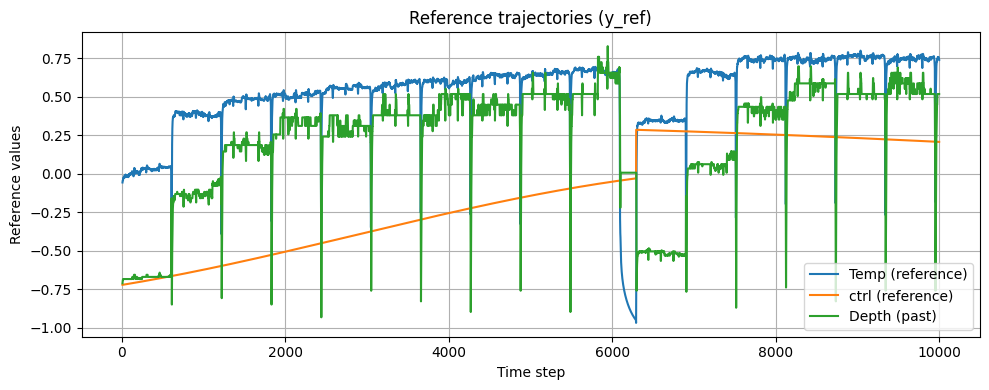

In [34]:
import matplotlib.pyplot as plt
import numpy as np

print(y_ref_train_seq.shape)
print(x_past_train.shape)
print(y_past_train.shape)
start_idx = 10
window = 10000-start_idx
y_ref_slice = y_ref_train_seq[start_idx : start_idx + window]
x_past_slice = x_past_train[start_idx : start_idx + window]
y_past_slice = y_past_train[start_idx : start_idx + window]
print(y_ref_slice.shape)
print(x_past_slice.shape)
print(y_past_slice.shape)


time_future = np.arange(start_idx, start_idx + window)

plt.figure(figsize=(10, 4))
plt.plot(time_future, y_past_slice[:, 0, 0], label="Temp (reference)")
plt.plot(time_future, x_past_slice[:, 0, 3], label="ctrl (reference)")
plt.plot(time_future, y_past_slice[:, 0, 1], label="Depth (past)")
plt.xlabel("Time step")
plt.ylabel("Reference values")
plt.title("Reference trajectories (y_ref)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


torch.Size([60942, 50, 1])
torch.Size([60942, 50, 4])
torch.Size([60942, 50, 2])
torch.Size([39900, 50, 1])
torch.Size([39900, 50, 4])
torch.Size([39900, 50, 2])


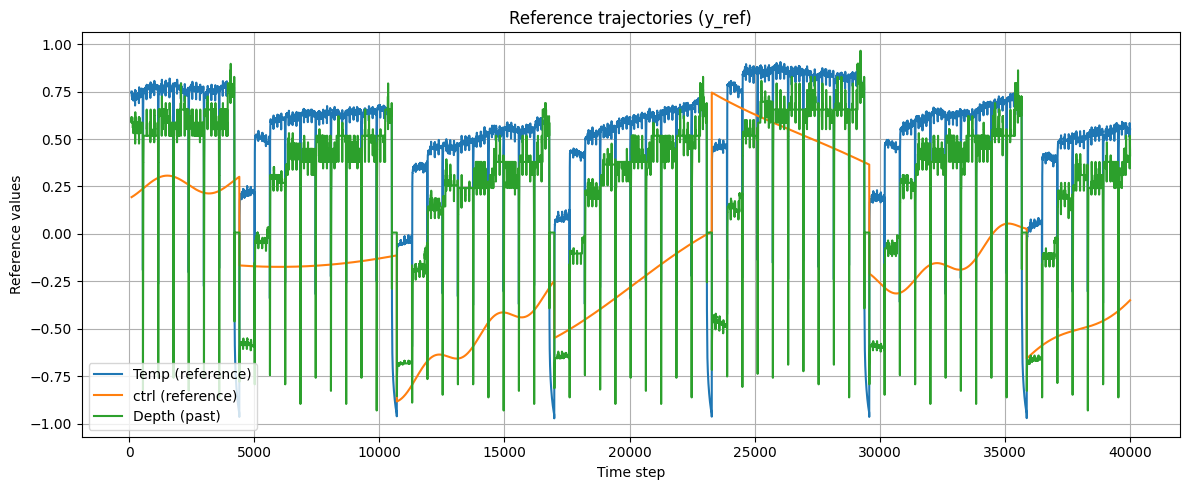

In [35]:
import matplotlib.pyplot as plt
import numpy as np

print(y_ref_val_seq.shape)
print(x_past_val.shape)
print(y_past_val.shape)
start_idx = 100
window = 40000-start_idx
y_ref_slice = y_ref_val_seq[start_idx : start_idx + window]
x_past_slice = x_past_val[start_idx : start_idx + window]
y_past_slice = y_past_val[start_idx : start_idx + window]
print(y_ref_slice.shape)
print(x_past_slice.shape)
print(y_past_slice.shape)


time_future = np.arange(start_idx, start_idx + window)

plt.figure(figsize=(12, 5))
plt.plot(time_future, y_past_slice[:, 0, 0], label="Temp (reference)")
plt.plot(time_future, x_past_slice[:, 0, 3], label="ctrl (reference)")
plt.plot(time_future, y_past_slice[:, 0, 1], label="Depth (past)")
plt.xlabel("Time step")
plt.ylabel("Reference values")
plt.title("Reference trajectories (y_ref)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
def val_TiDE(k, TiDE, val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const, u_shift, u_past_shift, c_shift, device, model_name=""):
    TiDE.eval()
    with torch.no_grad():
        x_past = val_x_past[k:k+1].to(device)
        x_past[:,:,3] += u_past_shift

        y_past = val_y_past[k:k+1].to(device)
        y_past[:,:,1] += c_shift

        x_future = val_x_future[k:k+1].to(device)

        # y_ref: [1, P, 1] + depth [1, P, 1] => [1, P, 2]
        y_ref_temp = val_y_ref[k:k+1].to(device)                  # [1, P, 1]
        y_ref_depth = val_y_past[k+50:k+51, :, 1:].to(device)     # [1, P, 1]
        y_ref = torch.cat([y_ref_temp, y_ref_depth], dim=2)       # [1, P, 2]

        x_past_2 = val_x_past[k+50:k+51].to(device)
        u_base = x_past_2[:, :, 3]
        u_pred = u_base.unsqueeze(-1) + u_shift

        x_future_tide = torch.cat((x_future, u_pred), dim=2)
        past_cov = torch.cat((y_past, x_past), dim=2)

        y_pred_all = TiDE((past_cov, x_future_tide, None))  # [1, P, 2, 3]

    y_pred = y_pred_all[:, :, :, 1].squeeze(0).cpu().numpy()  # [P, 2]
    y_ref = y_ref.squeeze(0).cpu().numpy()                    # [P, 2]

    abs_diff = np.abs(y_pred - y_ref)
    mae = np.mean(abs_diff, axis=0)
    rmse = np.sqrt(np.mean((y_pred - y_ref) ** 2, axis=0))
    y_ref_mean = np.mean(y_ref, axis=0)

    return mae, rmse, y_ref_mean


In [37]:
u_shift_values = [-0.1, 0.0, 0.1]
k_values = list(range(100, 500000, 50))
results = []

for u_shift in u_shift_values:
    for k in k_values:
        mae, rmse, y_ref_mean = val_TiDE(
            k=k,
            TiDE=TiDE,
            val_x_past=x_past_train,
            val_y_past=y_past_train,
            val_x_future=x_future_train,
            val_y_ref=y_ref_train_seq,
            val_y_const=y_const_train_seq,
            u_past_shift=0,
            u_shift=u_shift,
            c_shift=0,
            device=device
        )

        results.append({
            "k": k,
            "u_shift": u_shift,
            "Temp_MAE": mae[0],
            "Temp_RMSE": rmse[0],
            "Depth_MAE": mae[1],
            "Depth_RMSE": rmse[1],
            "Temp_ref_mean": y_ref_mean[0],
            "Depth_ref_mean": y_ref_mean[1]
        })

df_results = pd.DataFrame(results)
df_results.to_csv("/home/ftk3187/github/DPC_research/02_DED/2_policy/tide_eval_summary.csv", index=False)



In [38]:
import numpy as np
import pandas as pd

# 온도 구간 정의 (0.1 단위 binning)
bin_edges = np.arange(df_results["Temp_ref_mean"].min(), df_results["Temp_ref_mean"].max() + 0.1, 0.1)
bin_labels = [f"{round(bin_edges[i], 2)}–{round(bin_edges[i+1], 2)}" for i in range(len(bin_edges)-1)]

# 온도 구간(bin) 컬럼 생성
df_results["Temp_bin"] = pd.cut(df_results["Temp_ref_mean"], bins=bin_edges, labels=bin_labels, include_lowest=True)

# 온도 구간과 u_shift 별 평균 성능 지표 계산
grouped = df_results.groupby(["Temp_bin", "u_shift"]).agg({
    "Temp_RMSE": "mean",
    "Temp_MAE": "mean",
    "Depth_MAE": "mean",
    "Depth_RMSE": "mean"
}).reset_index()

# 테이블 형식 정리
pivot_table = grouped.pivot(index="Temp_bin", columns="u_shift")
pivot_table.columns = ['_'.join([metric, str(shift)]) for metric, shift in pivot_table.columns]
pivot_table = pivot_table.reset_index()

# 결과 출력
import pandas as pd
from IPython.display import display


# Count samples in each temperature bin
bin_counts = df_results.groupby("Temp_bin").size().reset_index(name='sample_count')

# Merge the bin counts with the existing pivot table
pivot_table_with_counts = pd.merge(pivot_table, bin_counts, on="Temp_bin", how='left')

# Reorder columns to show sample count first
cols = pivot_table_with_counts.columns.tolist()
cols.insert(1, cols.pop()) # Move sample_count to second position after Temp_bin

pivot_table_with_counts = pivot_table_with_counts[cols]

# Display the updated table with sample counts
display(pivot_table_with_counts)

# Optional: Print total sample count
total_samples = bin_counts['sample_count'].sum()
print(f"\nTotal number of samples: {total_samples}")

# Optional: Calculate percentage of samples in each bin
pivot_table_with_counts['sample_percentage'] = (pivot_table_with_counts['sample_count'] / total_samples * 100).round(2)



,Temp_bin,sample_count,Temp_RMSE_-0.1,Temp_RMSE_0.0,Temp_RMSE_0.1,Temp_MAE_-0.1,Temp_MAE_0.0,Temp_MAE_0.1,Depth_MAE_-0.1,Depth_MAE_0.0,Depth_MAE_0.1,Depth_RMSE_-0.1,Depth_RMSE_0.0,Depth_RMSE_0.1
0,-0.94–-0.84,423,0.010996,0.011228,0.012014,0.007758,0.007812,0.008362,0.006565,0.006402,0.006993,0.009504,0.009071,0.009495
1,-0.84–-0.74,246,0.012715,0.010597,0.010698,0.008902,0.007171,0.006983,0.009822,0.008863,0.009436,0.013146,0.011904,0.012735
2,-0.74–-0.64,102,0.041023,0.036882,0.037255,0.030185,0.026571,0.027069,0.021354,0.020289,0.024609,0.032334,0.029410,0.033177
3,-0.64–-0.54,48,0.095480,0.073938,0.075172,0.080652,0.057564,0.058019,0.058670,0.051908,0.055131,0.082083,0.073369,0.074151
4,-0.54–-0.44,27,0.125715,0.081920,0.083815,0.107192,0.064285,0.064541,0.105276,0.068269,0.074498,0.126089,0.089326,0.092847
5,-0.44–-0.34,45,0.101594,0.066818,0.074756,0.080688,0.046533,0.052067,0.069863,0.042281,0.043236,0.095241,0.063247,0.061002
6,-0.34–-0.24,36,0.107756,0.075921,0.081611,0.079788,0.047170,0.051675,0.081364,0.043183,0.041512,0.105206,0.063613,0.059203
7,-0.24–-0.14,33,0.125463,0.077910,0.084218,0.094490,0.051022,0.057067,0.098379,0.050070,0.046913,0.129901,0.071868,0.065720
8,-0.14–-0.04,90,0.076562,0.041106,0.047280,0.055294,0.027396,0.032699,0.053089,0.027315,0.026634,0.073995,0.041086,0.038999
9,-0.04–0.06,357,0.032456,0.017623,0.025740,0.023603,0.012660,0.017882,0.017583,0.010783,0.014815,0.026807,0.016793,0.021295



Total number of samples: 29994


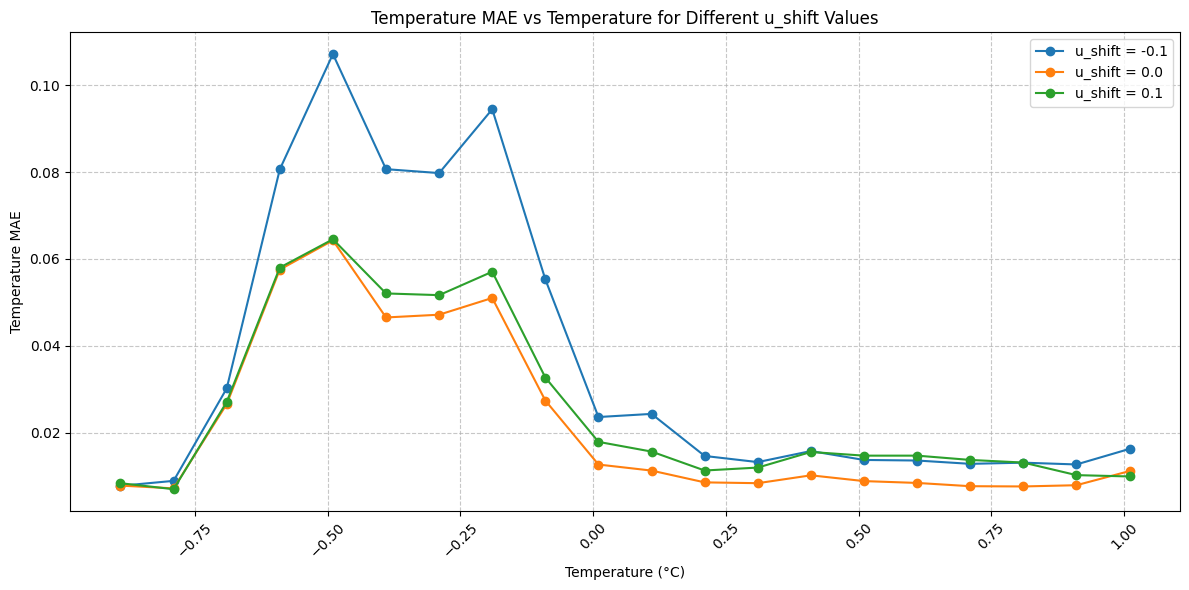

In [39]:
import matplotlib.pyplot as plt

# Extract temperature values from bin labels (using mid-point of each bin)
pivot_table['Temp_mid'] = pivot_table['Temp_bin'].apply(lambda x: float(x.split('–')[0]) + 0.05)

# Create the line plot
plt.figure(figsize=(12, 6))

# Plot lines for each u_shift value
plt.plot(pivot_table['Temp_mid'], pivot_table['Temp_MAE_-0.1'], 'o-', label='u_shift = -0.1')
plt.plot(pivot_table['Temp_mid'], pivot_table['Temp_MAE_0.0'], 'o-', label='u_shift = 0.0')
plt.plot(pivot_table['Temp_mid'], pivot_table['Temp_MAE_0.1'], 'o-', label='u_shift = 0.1')

# Customize the plot
plt.xlabel('Temperature (°C)')
plt.ylabel('Temperature MAE')
plt.title('Temperature MAE vs Temperature for Different u_shift Values')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


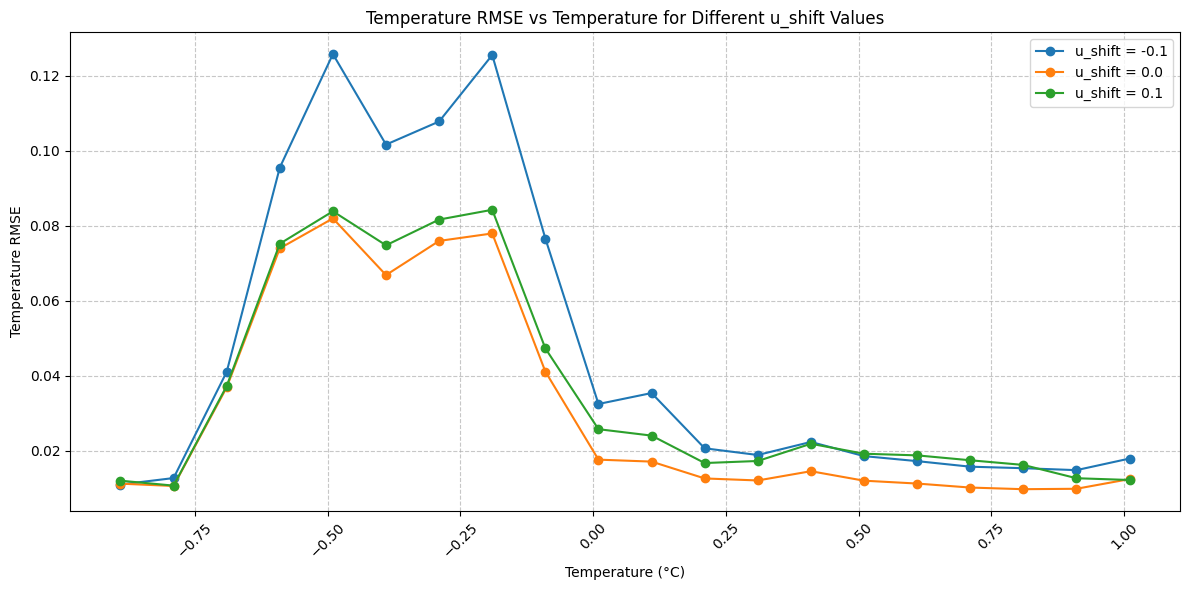

In [40]:
import matplotlib.pyplot as plt

# Extract temperature values from bin labels (using mid-point of each bin)
pivot_table['Temp_mid'] = pivot_table['Temp_bin'].apply(lambda x: float(x.split('–')[0]) + 0.05)

# Create the line plot
plt.figure(figsize=(12, 6))

# Plot lines for each u_shift value
plt.plot(pivot_table['Temp_mid'], pivot_table['Temp_RMSE_-0.1'], 'o-', label='u_shift = -0.1')
plt.plot(pivot_table['Temp_mid'], pivot_table['Temp_RMSE_0.0'], 'o-', label='u_shift = 0.0')
plt.plot(pivot_table['Temp_mid'], pivot_table['Temp_RMSE_0.1'], 'o-', label='u_shift = 0.1')

# Customize the plot
plt.xlabel('Temperature (°C)')
plt.ylabel('Temperature RMSE')
plt.title('Temperature RMSE vs Temperature for Different u_shift Values')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


In [41]:
def val_TiDE_noise(k, TiDE, val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const, noise_std, u_past_shift, c_shift, device, model_name=""):
    TiDE.eval()
    with torch.no_grad():
        x_past = val_x_past[k:k+1].to(device)
        x_past[:,:,3] += u_past_shift

        y_past = val_y_past[k:k+1].to(device)
        y_past[:,:,1] += c_shift

        x_future = val_x_future[k:k+1].to(device)

        # y_ref: [1, P, 1] + depth [1, P, 1] => [1, P, 2]
        y_ref_temp = val_y_ref[k:k+1].to(device)                  # [1, P, 1]
        y_ref_depth = val_y_past[k+50:k+51, :, 1:].to(device)     # [1, P, 1]
        y_ref = torch.cat([y_ref_temp, y_ref_depth], dim=2)       # [1, P, 2]

        x_past_2 = val_x_past[k+50:k+51].to(device)
        u_base = x_past_2[:, :, 3]
        
        # Generate Gaussian noise
        noise = torch.normal(mean=0.0, std=noise_std, size=u_base.shape).to(device)
        u_pred = u_base.unsqueeze(-1) + noise.unsqueeze(-1)

        x_future_tide = torch.cat((x_future, u_pred), dim=2)
        past_cov = torch.cat((y_past, x_past), dim=2)

        y_pred_all = TiDE((past_cov, x_future_tide, None))  # [1, P, 2, 3]

    y_pred = y_pred_all[:, :, :, 1].squeeze(0).cpu().numpy()  # [P, 2]
    y_ref = y_ref.squeeze(0).cpu().numpy()                    # [P, 2]

    abs_diff = np.abs(y_pred - y_ref)
    mae = np.mean(abs_diff, axis=0)
    rmse = np.sqrt(np.mean((y_pred - y_ref) ** 2, axis=0))
    y_ref_mean = np.mean(y_ref, axis=0)

    return mae, rmse, y_ref_mean


In [42]:
noise_std_values = [0.0, 0.1, 0.2]
k_values = list(range(100, 500000, 50))
results = []

for noise_std in noise_std_values:
    for k in k_values:
        mae, rmse, y_ref_mean = val_TiDE_noise(
            k=k,
            TiDE=TiDE,
            val_x_past=x_past_train,
            val_y_past=y_past_train,
            val_x_future=x_future_train,
            val_y_ref=y_ref_train_seq,
            val_y_const=y_const_train_seq,
            u_past_shift=0,
            noise_std = noise_std,
            c_shift=0,
            device=device
        )

        results.append({
            "k": k,
            "noise_std": noise_std,
            "Temp_MAE": mae[0],
            "Temp_RMSE": rmse[0],
            "Depth_MAE": mae[1],
            "Depth_RMSE": rmse[1],
            "Temp_ref_mean": y_ref_mean[0],
            "Depth_ref_mean": y_ref_mean[1]
        })

df_noise_results = pd.DataFrame(results)
df_noise_results.to_csv("/home/ftk3187/github/DPC_research/02_DED/2_policy/tide_eval_noise_summary.csv", index=False)



In [43]:
import numpy as np
import pandas as pd

# 온도 구간 정의 (0.1 단위 binning)
bin_edges = np.arange(df_noise_results["Temp_ref_mean"].min(), df_noise_results["Temp_ref_mean"].max() + 0.1, 0.1)
bin_labels = [f"{round(bin_edges[i], 2)}–{round(bin_edges[i+1], 2)}" for i in range(len(bin_edges)-1)]

# 온도 구간(bin) 컬럼 생성
df_noise_results["Temp_bin"] = pd.cut(df_noise_results["Temp_ref_mean"], bins=bin_edges, labels=bin_labels, include_lowest=True)

# 온도 구간과 u_shift 별 평균 성능 지표 계산
grouped = df_noise_results.groupby(["Temp_bin", "noise_std"]).agg({
    "Temp_RMSE": "mean",
    "Temp_MAE": "mean",
    "Depth_MAE": "mean",
    "Depth_RMSE": "mean"
}).reset_index()

# 테이블 형식 정리
pivot_table = grouped.pivot(index="Temp_bin", columns="noise_std")
pivot_table.columns = ['_'.join([metric, str(shift)]) for metric, shift in pivot_table.columns]
pivot_table = pivot_table.reset_index()

from IPython.display import display


# Count samples in each temperature bin
bin_counts = df_noise_results.groupby("Temp_bin").size().reset_index(name='sample_count')

# Merge the bin counts with the existing pivot table
pivot_table_with_counts = pd.merge(pivot_table, bin_counts, on="Temp_bin", how='left')

# Reorder columns to show sample count first
cols = pivot_table_with_counts.columns.tolist()
cols.insert(1, cols.pop()) # Move sample_count to second position after Temp_bin

pivot_table_with_counts = pivot_table_with_counts[cols]

# Display the updated table with sample counts
display(pivot_table_with_counts)

# Optional: Print total sample count
total_samples = bin_counts['sample_count'].sum()
print(f"\nTotal number of samples: {total_samples}")

# Optional: Calculate percentage of samples in each bin
pivot_table_with_counts['sample_percentage'] = (pivot_table_with_counts['sample_count'] / total_samples * 100).round(2)



,Temp_bin,sample_count,Temp_RMSE_0.0,Temp_RMSE_0.1,Temp_RMSE_0.2,Temp_MAE_0.0,Temp_MAE_0.1,Temp_MAE_0.2,Depth_MAE_0.0,Depth_MAE_0.1,Depth_MAE_0.2,Depth_RMSE_0.0,Depth_RMSE_0.1,Depth_RMSE_0.2
0,-0.94–-0.84,423,0.011228,0.011725,0.012874,0.007812,0.008154,0.008860,0.006402,0.006604,0.007027,0.009071,0.009387,0.009949
1,-0.84–-0.74,246,0.010597,0.011467,0.014198,0.007171,0.007848,0.009818,0.008863,0.009424,0.010989,0.011904,0.012709,0.014797
2,-0.74–-0.64,102,0.036882,0.037995,0.039311,0.026571,0.027605,0.028640,0.020289,0.021086,0.022655,0.029410,0.030219,0.032276
3,-0.64–-0.54,48,0.073938,0.074720,0.078668,0.057564,0.058857,0.061864,0.051908,0.052133,0.050929,0.073369,0.074617,0.072146
4,-0.54–-0.44,27,0.081920,0.083374,0.088904,0.064285,0.066053,0.067629,0.068269,0.068299,0.072238,0.089326,0.088850,0.095417
5,-0.44–-0.34,45,0.066818,0.071431,0.080233,0.046533,0.050701,0.058107,0.042281,0.040374,0.046840,0.063247,0.062081,0.066152
6,-0.34–-0.24,36,0.075921,0.078207,0.083496,0.047170,0.049959,0.055401,0.043183,0.042956,0.046081,0.063613,0.063272,0.065906
7,-0.24–-0.14,33,0.077910,0.078791,0.084782,0.051022,0.053491,0.060617,0.050070,0.049939,0.051557,0.071868,0.070341,0.073125
8,-0.14–-0.04,90,0.041106,0.045224,0.052969,0.027396,0.031140,0.037501,0.027315,0.028315,0.032049,0.041086,0.041947,0.046642
9,-0.04–0.06,357,0.017623,0.023626,0.032023,0.012660,0.016914,0.023650,0.010783,0.012194,0.015321,0.016793,0.018945,0.022575



Total number of samples: 29994


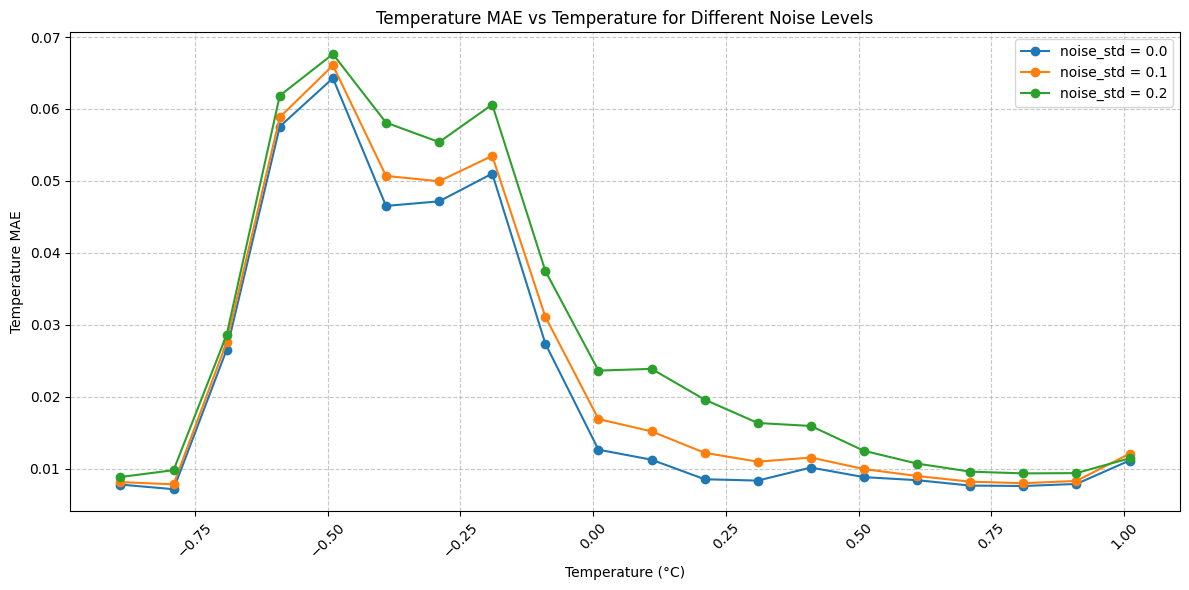

In [44]:
import matplotlib.pyplot as plt

# Extract temperature values from bin labels (using mid-point of each bin)
pivot_table['Temp_mid'] = pivot_table['Temp_bin'].apply(lambda x: float(x.split('–')[0]) + 0.05)

# Create the line plot
plt.figure(figsize=(12, 6))

# Plot lines for each noise_std value
plt.plot(pivot_table['Temp_mid'], pivot_table['Temp_MAE_0.0'], 'o-', label='noise_std = 0.0')
plt.plot(pivot_table['Temp_mid'], pivot_table['Temp_MAE_0.1'], 'o-', label='noise_std = 0.1')
plt.plot(pivot_table['Temp_mid'], pivot_table['Temp_MAE_0.2'], 'o-', label='noise_std = 0.2')

# Customize the plot
plt.xlabel('Temperature (°C)')
plt.ylabel('Temperature MAE')
plt.title('Temperature MAE vs Temperature for Different Noise Levels')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


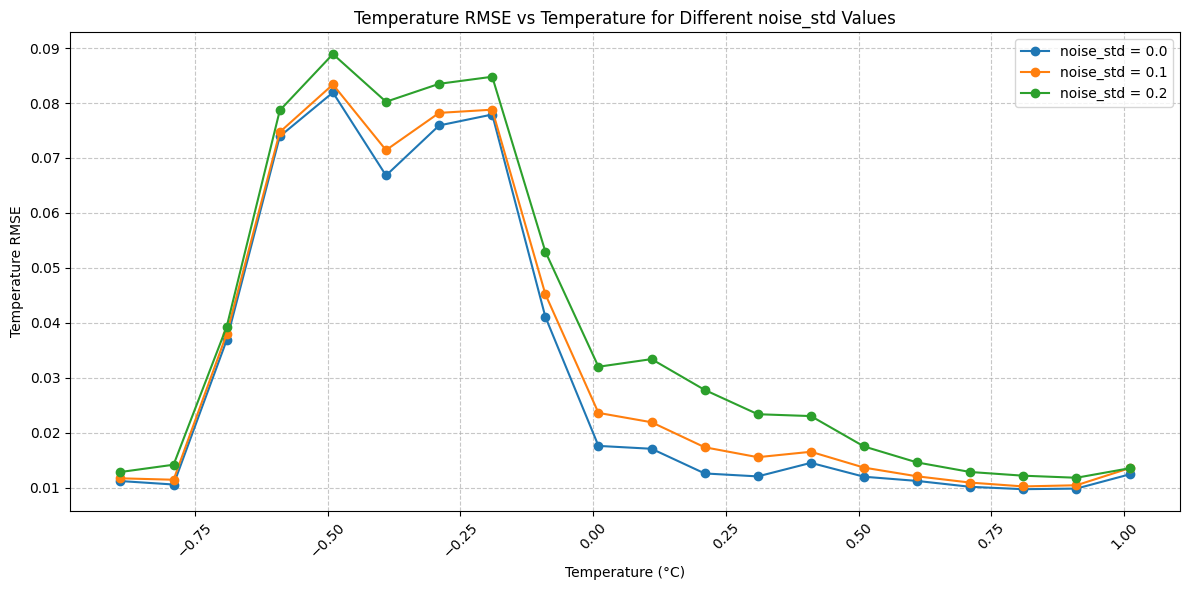

In [46]:
import matplotlib.pyplot as plt

# Extract temperature values from bin labels (using mid-point of each bin)
pivot_table['Temp_mid'] = pivot_table['Temp_bin'].apply(lambda x: float(x.split('–')[0]) + 0.05)

# Create the line plot
plt.figure(figsize=(12, 6))

# Plot lines for each u_shift value
plt.plot(pivot_table['Temp_mid'], pivot_table['Temp_RMSE_0.0'], 'o-', label='noise_std = 0.0')
plt.plot(pivot_table['Temp_mid'], pivot_table['Temp_RMSE_0.1'], 'o-', label='noise_std = 0.1')
plt.plot(pivot_table['Temp_mid'], pivot_table['Temp_RMSE_0.2'], 'o-', label='noise_std = 0.2')


# Customize the plot
plt.xlabel('Temperature (°C)')
plt.ylabel('Temperature RMSE')
plt.title('Temperature RMSE vs Temperature for Different noise_std Values')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()
